# The tool for updating the model and determining pipe leak probabilities

This notebook is a script to be run every particular time interval and if any data updates have been made the model model parameters will get updated accordingly and new pipe leak predictions will be computed based on these new parameters and observations on the pipes.  The first part presents the logic for the update of model parameters and the second presents the use of observed pipe characteric values to infer pipe leak probabilities.

In [1]:
#Importing the dependencies
import pandas as pd
import numpy as np
from collections import Counter
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import ParameterEstimator
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination, Inference
import matplotlib.pyplot as plt
import seaborn as sns
# Confusion Matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score,accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_curve,auc,f1_score
#Mathews correlation metric
from sklearn.metrics import matthews_corrcoef
# For resampling
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

In [2]:
# defining output formatting
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Model Development

### Indentifying variables of intereset
The model variables and parameters used for the simulation of data used to in examplyfying the Bayesian parameter updating approach for modelling risk of pipe leaks in water distribution systems where adopted from (Ogutu,2018).
.

Indentifying the model variables;
The model variables adopted from (oguto, 2018), their coresponding probabilities distributions and the possible values that each variable can assume are presented in Table...

!! column names inclued (Node or variable name), Distribution, values.

Soil_type = St ;
Material_type = Mt ;
Diameter = Di ; 
Location = Lo ;
Strain = Sn ;
Damage = Dg ;
Defects = Df ;
Corrosion = Cr ;
Leakage = Lk ;

## Reference
Ogutu, A.G., Kogeda, O.P. and Lall, M., 2018. A Probabilistic Assessment of Location Dependent Failure Trends in South African Water Distribution Networks. In Proceedings of the International MultiConference of Engineers and Computer Scientists (Vol. 1)

Bayesian network Structure


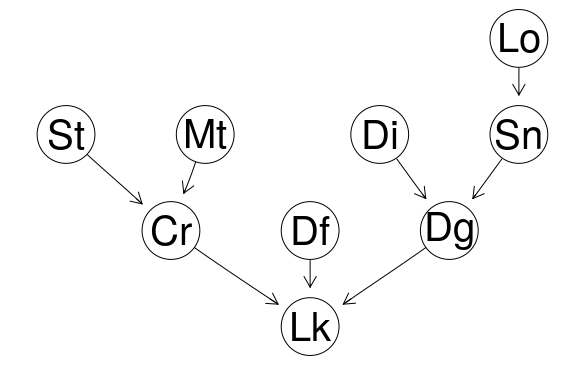

In [3]:
# Bayesian network structure from which data was simulated and data-adaptive approach assessed
from IPython.display import Image
print('Bayesian network Structure')
Image(filename='bn_dag.png')

## Defining prior model, with uniform Dirichlet distributions

In [4]:
# Defining model structure
model_structure = BayesianModel([('St', 'Cr'), ('Mt', 'Cr'), ('Di', 'Dg'), ('Lo', 'Sn'), ('Sn', 'Dg'), ('Dg', 'Lk'),('Cr', 'Lk'), ('Df', 'Lk')])

In [5]:
## Variable states
state_names = {'St': ("dolomite", "regular"),'Mt': ("ACD", "HDPE", "steel","Upvc"),'Cr':("No","Yes"),
               'Df':(False,True),'Lo':("Erf", "Exit"),'Sn':("NoStrain","Low","High"),'Di':("Small", "Medium", "Large"),
               'Dg':("No","Yes"),'Lk':("Negative","Positive")}
# Prior model: As index 0 in the collection of update moments
Prior_Dir_params = {'St': np.ones((2,1)),'Mt' : np.ones((4,1)), 'Cr': np.ones((2,8)),'Df': np.ones((2,1)),'Lo': np.ones((2,1)),
          'Sn':np.ones((3,2)),'Di':np.ones((3,1)),'Dg':np.ones((2,9)) ,'Lk': np.ones((2,8))}

In [6]:
# import the simulated data (Simulated in R see link to the simulation code in R) with these variables
df = pd.read_csv('simulated_training_set.csv')

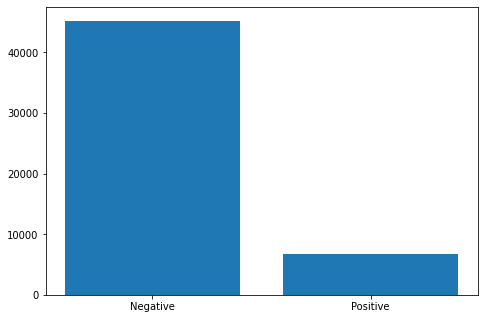

In [7]:
#import matplotlib.pyplot as plt
class_freq = Counter(df["Lk"])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = ['Negative', 'Positive']
leak_state = [class_freq['Negative'],class_freq['Positive']]
ax.bar(values,leak_state)
plt.show()

In [8]:
# Splitting dataframe into 1000 subsets each of size 100 for simulating incoming data batches for parameter updating
sub_sample_size = 200
update_data_batches = np.array_split(df, len(df)/sub_sample_size)
print(len(update_data_batches))

260


In [9]:
len(update_data_batches[0])

200

In [ ]:
data_len = 0
data = pd.read_csv('')

if data.shape[0] > data_len
# lenghth check
data_len = data.shape[0]

In [ ]:
# The model updating function
def model_updater(data_frame,model_structure):
    upd_priors = {}
    upd_posterior = {}
    #Prior_Dir_params = Prior_Dir_params
    upd_posterior.update({0:Prior_Dir_params})
    for i in range(len(update_data_batches)):
        prior = Prior_Dir_params
        upd_priors.update({i:prior}) #holding k-1 updated parameters 'final posterior to be accesed from Prior_Dirparams
        # model fitting and counts obtaining
        #Since model counts are the ones of interest in terms of parameter updating
        #We only use model.fit to obtain the model most recently estimated
        #model_structure.fit(update_data_batches[i],estimator = BayesianEstimator, prior_type="dirichlet", state_names = state_names, pseudo_counts=prior)
        #
        estimator = ParameterEstimator(model_structure, update_data_batches[i], state_names = state_names) # fitting model for obtaining counts only
        Post={}
        for ky in Prior_Dir_params.keys():
            Post.update({ky:estimator.state_counts(ky).values + Prior_Dir_params[ky]})
        #updating to posterior
        upd_posterior.update({i+1:Post}) # Contanings all history of parameter updates
        Prior_Dir_params = Post

In [10]:
# Updating model parameters. Each subset of data being passed at a time and updating prior parameters accordingly
# A thousand updates have been performed here with all updated posterior distributions being stored at every update point
upd_priors = {}
upd_posterior = {}
#Prior_Dir_params = Prior_Dir_params
upd_posterior.update({0:Prior_Dir_params})
for i in range(len(update_data_batches)):
    prior = Prior_Dir_params
    upd_priors.update({i:prior}) #holding k-1 updated parameters 'final posterior to be accesed from Prior_Dirparams
    # model fitting and counts obtaining
    #Since model counts are the ones of interest in terms of parameter updating
    #We only use model.fit to obtain the model most recently estimated
    #model_structure.fit(update_data_batches[i],estimator = BayesianEstimator, prior_type="dirichlet", state_names = state_names, pseudo_counts=prior)
    #
    estimator = ParameterEstimator(model_structure, update_data_batches[i], state_names = state_names) # fitting model for obtaining counts only
    Post={}
    for ky in Prior_Dir_params.keys():
        Post.update({ky:estimator.state_counts(ky).values + Prior_Dir_params[ky]})
    #updating to posterior
    upd_posterior.update({i+1:Post}) # Contanings all history of parameter updates
    Prior_Dir_params = Post #final update parameters (Most updated model)
    #print(model.get_cpds(node='St').values)
    

In [11]:
upd_posterior

{0: {'St': array([[1.000],
         [1.000]]),
  'Mt': array([[1.000],
         [1.000],
         [1.000],
         [1.000]]),
  'Cr': array([[1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
         [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000]]),
  'Df': array([[1.000],
         [1.000]]),
  'Lo': array([[1.000],
         [1.000]]),
  'Sn': array([[1.000, 1.000],
         [1.000, 1.000],
         [1.000, 1.000]]),
  'Di': array([[1.000],
         [1.000],
         [1.000]]),
  'Dg': array([[1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
         [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000]]),
  'Lk': array([[1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
         [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000]])},
 1: {'St': array([[21.000],
         [181.000]]),
  'Mt': array([[9.000],
         [63.000],
         [33.000],
         [99.000]]),
  'Cr': array([[1.000, 8.000, 8.000, 56.000, 3.000, 21.000, 12.000

In [13]:
model_structure.get_cpds('Lk').values

array([[[[1.000, 0.498],
         [0.982, 0.490]],

        [[0.990, 0.483],
         [0.929, 0.071]]],


       [[[0.000, 0.502],
         [0.018, 0.510]],

        [[0.010, 0.517],
         [0.071, 0.929]]]])

In [14]:
# This is for the model that has to be part of the automated updating model 
# Updating model parameters. Each subset of data being passed at a time and updating prior parameters accordingly
# A thousand updates have been performed here with all updated posterior distributions being stored at every update point
def model_updated(updated_data,model_structure,state_names,prior_parameters):
    """This is the model to update the Bayesian network parameters based on new datasets observed
       Inputs: 
               data: The most recently observed dataset(complete) (atleast 1 row).
               model_structure: Defined Bayesian network structure
               state_names: state_names
               prior_parameters: prior_model parameters
       Output: Updated model parameters"""
    upd_priors = {}
    upd_posterior = {}
    Prior_Dir_params = prior_parameters
    #for i in range(len(update_data_batches)):
    #prior = Prior_Dir_params
    upd_priors.update({i:prior}) #holding k-1 updated parameters 'final posterior to be accesed from Prior_Dirparams
    # model fitting and counts obtaining
    #Since model counts are the ones of interest in terms of parameter updating
    #We only use model.fit to obtain the model most recently estimated
    model_structure.fit(updated_data,estimator = BayesianEstimator, prior_type="dirichlet", 
                                                            state_names = state_names, pseudo_counts=Prior_Dir_params)
    estimator = ParameterEstimator(model_structure, updated_data,
                                   state_names = state_names) # fitting model for obtaining counts only
    Post={}
    for ky in Prior_Dir_params.keys():
        Post.update({ky:estimator.state_counts(ky).values + Prior_Dir_params[ky]})
    #updating to posterior
    #upd_posterior.update({i:Post})
    Prior_Dir_params = Post #final update parameters (Most updated model)
    return Prior_Dir_params
    

### Assessing parameter updating over the 1000 updates


In [15]:
# seting the background dictionaries to link node names and values to array indices for parameter sampling
# Mapping parent node configurations
parent_config_mapping = {"Cr":{('ACD','dolomite'):0, ('ACD','regular'):1,
                               ('HDPE','dolomite'):2, ('HDPE','regular'):3,
                               ('steel','dolomite'):4, ('steel','regular'):5,
                               ('Upvc','dolomite'):6, ('Upvc','regular'):7},
                        "Lk": {('No',False,'No'):0,('No',False,'Yes'):1, 
                               ('No',True,'No'):2,('No',True,'Yes'):3, 
                               ('Yes',False,'No'):4,('Yes',False,'Yes'):5, 
                               ('Yes',True,'No'):6,('Yes',True,'Yes'):7},
                        "Sn": {('Erf',):0,('Exit',):1},
                        "Dg": {('Small','Nostrain'):0,('Small','Low'):1,('Small','High'):2,
                              ('Medium','Nostrain'):3,('Medium','Low'):4,('Medium','High'):5,
                              ('Large','Nostrain'):6,('Large','Low'):7,('Large','High'):8},
                        'St':{None:0},
                        'Lo':{None:0},
                        'Di':{None:0},
                        'Mt':{None:0},
                        'Df':{None:0}}
#Mapping from node value to integers for arrays
child_value_mapping = {  'St': {'dolomite':0, 'regular':1},
                         'Cr': {'No':0, 'Yes':1},
                         'Mt': {'ACD':0, 'HDPE':1, 'steel':2, 'Upvc':3},
                         'Di': {'Small':0, 'Medium':1, 'Large':2},
                         'Dg': {'No':0 ,'Yes': 1},
                         'Sn': {'NoStrain':0, 'Low':1, 'High':2},
                         'Lo': {'Erf':0, 'Exit':1},
                         'Lk': {'Negative': 0, 'Positive': 1},
                         'Df': {False : 0,  True : 1}}
child_value_mapping_reversed = {'St': {0:'dolomite', 1:'regular'},
 'Cr': {0: 'No', 1: 'Yes'},
 'Mt': {0: 'ACD', 1: 'HDPE', 2: 'steel', 3: 'Upvc'},
 'Di': {0: 'Small', 1: 'Medium', 2: 'Large'},
 'Dg': {0: 'No' , 1: 'Yes'},
 'Sn': {0: 'NoStrain', 1: 'Low',2: 'High'},
 'Lo': {0: 'Erf', 1: 'Exit'},
 'Lk': {0: 'Negative', 1: 'Positive'},
 'Df': {0: False , 1: True }}

# True parameters
actual_params = {'Cr': np.array([[0.96,0.71,1.0,1.0,0.96,0.71,1.0,1.0],[0.04,0.29,0.0,0.0,0.04,0.29,0.0,0.0]]),
                 'Lk': np.array([[1,0.5,0.98,0.5,0.988,0.488,0.95,0.02],[0,0.5,0.02,0.5,0.012,0.512,0.05,0.98]]),
                 'Dg': np.array([[0.88, 0.84,0.36,0.973,0.88,0.48,0.975,0.92,0.56],[0.12,0.16,0.64,0.027,0.12,0.52,0.025,0.08,0.44]]),
                 'Sn': np.array([[0.36, 0.16],[0.52, 0.2],[0.12,0.64]]),
                 'St': np.array([[0.078],[0.922]]),
                 'Lo':np.array([[0.633],[0.367]]),
                 'Di':np.array([[0.546],[0.35],[0.104]]),
                 'Mt':np.array([[0.057],[0.34],[0.157],[0.446]]),
                 'Df':np.array([[0.98],[0.02]])}
# Parents of nodes alphabetically arranged



In [16]:
#0.04,0.96,0.29,0.71,0.0,1.0,0.0,1.0,0.04,0.96,0.29,0.71,0.0,1.0,0.0,1.0)

In [17]:
def cpt_sampler(node,dir_post_params):
    '''Given dirichlet posterior parameters this function is for sampling node cpt parameter values 
       Give me a cpt Dirichelet parameters, I'll give you back a cpt containing 1 sample parameter for each multinomial
       parameter of the cpt.
    input : 
            Node for which we want to get cpt
            Posterior parameter
    Output : Sample posterior cpt parameters given the posterior dirichlet parameter 
    '''
    dim = dir_post_params[len(dir_post_params)-1][node].shape # Change 100 index such that it represents the most recent updata
    cpt_sample_post = np.zeros(dim)
    for i in range(dim[1]):
        cpt_sample_post[:,i] = np.random.dirichlet(dir_post_params[len(dir_post_params)-1][node][:,i].flatten())
    return cpt_sample_post

In [18]:
#Defining sampling parameters from posterior dirichelet to facilitate their plotting and assessment over updates
def sample_cpt(node,dir_post_params,update = 0):
    '''Given dirichlet posterior parameters this function is for sampling node cpt parameters
    input : 
            node: for which we want to get cpt
            Posterior parameter
            update: the update number in reverse order. 1 implies most recent update, and total_number_of_updates is
            for the 1st update."Allow to get samples over multiple update points"
    Output : Sample posterior cpt parameters given the posterior dirichlet parameter 
    '''
    dim = dir_post_params[update][node].shape # Change 100 index such that it represents the most recent update
    cpt_sample_post = np.zeros(dim)
    for i in range(dim[1]):
        cpt_sample_post[:,i] = np.random.dirichlet(dir_post_params[update][node][:,i].flatten())
    return cpt_sample_post

def multiple_sample(node,dir_post_params,update=1,n=1000):
    """Sampling multiple times for each cpts parameter estimate
        input : 
            node: for which we want to get cpt
            Posterior parameter
            update: 
    Output : Sample posterior cpt parameters given the posterior dirichlet parameter 
    """
    multi_samples = np.zeros((update,n,sample_cpt(node,dir_post_params,update).shape[0],sample_cpt(node,dir_post_params,update).shape[1]))
    samples = np.zeros((n,sample_cpt(node,dir_post_params,update).shape[0],sample_cpt(node,dir_post_params,update).shape[1]))

    for j in range(update):        
        for i in range(n):
            samples[i,:,:] = sample_cpt(node,dir_post_params,j)
        multi_samples[j,:,:,:] = samples      
    return multi_samples   


In [19]:
def multiple_sample_intrim(node,dir_post_params,update=1,n=1000):
    """Sampling multiple times for each cpts parameter estimate
        input : 
            node: for which we want to get cpt
            Posterior parameter
            update: 
    Output : Sample posterior cpt parameters given the posterior dirichlet parameter 
    """
    multi_samples = np.zeros((update+1,n,sample_cpt(node,dir_post_params,update+1).shape[0],sample_cpt(node,dir_post_params,update+1).shape[1]))
    samples = np.zeros((n,sample_cpt(node,dir_post_params,update+1).shape[0],sample_cpt(node,dir_post_params,update+1).shape[1]))

    for j in range(update+1):        
        for i in range(n):
            samples[i,:,:] = sample_cpt(node,dir_post_params,j)
        multi_samples[j,:,:,:] = samples      
    return multi_samples   

In [20]:
multiple_sample_intrim('Lk',upd_posterior,update=1,n=10)

array([[[[0.781, 0.701, 0.335, 0.572, 0.739, 0.024, 0.128, 0.174],
         [0.219, 0.299, 0.665, 0.428, 0.261, 0.976, 0.872, 0.826]],

        [[0.559, 0.115, 0.190, 0.950, 0.186, 0.416, 0.590, 0.919],
         [0.441, 0.885, 0.810, 0.050, 0.814, 0.584, 0.410, 0.081]],

        [[0.265, 0.215, 0.516, 0.855, 0.281, 0.768, 0.878, 0.707],
         [0.735, 0.785, 0.484, 0.145, 0.719, 0.232, 0.122, 0.293]],

        [[0.845, 0.751, 0.174, 0.649, 0.644, 0.029, 0.489, 0.188],
         [0.155, 0.249, 0.826, 0.351, 0.356, 0.971, 0.511, 0.812]],

        [[0.140, 0.638, 0.431, 0.985, 0.384, 0.922, 0.490, 0.277],
         [0.860, 0.362, 0.569, 0.015, 0.616, 0.078, 0.510, 0.723]],

        [[0.871, 0.232, 0.181, 0.579, 0.752, 0.700, 0.171, 0.210],
         [0.129, 0.768, 0.819, 0.421, 0.248, 0.300, 0.829, 0.790]],

        [[0.930, 0.426, 0.905, 0.333, 0.953, 0.104, 0.087, 0.157],
         [0.070, 0.574, 0.095, 0.667, 0.047, 0.896, 0.913, 0.843]],

        [[0.029, 0.027, 0.454, 0.045, 0.301, 0.2

In [21]:
estimator.state_counts('St')

,St
dolomite,12
regular,188


In [36]:
# plotting functions for the posterior parameters in comparison to the true parameter value
# input from function above
def post_plotter(cpt_param_upd,child_instatiation = 0,Parent_instatiation = 0):
    
    #child_instatiation = 0 # You can adjust child instatiations (0=neg,1=pos)
    #Parent_instatiation = 7 # Different joint parent instatiations
    Lb = [np.percentile(cpt_param_upd[i,:,child_instatiation,Parent_instatiation], 2.5) for i in range(cpt_param_upd.shape[0])]
    Ub = [np.percentile(cpt_param_upd[i,:,child_instatiation,Parent_instatiation], 97.5) for i in range(cpt_param_upd.shape[0])]
    x = [i for i in range(cpt_param_upd.shape[0])]
    #return Lb
    plt.fill_between(x, Lb, Ub, alpha=0.2, color='tab:blue')
    plt.plot([cpt_param_upd[i,:,child_instatiation,Parent_instatiation].mean() for i in range(cpt_param_upd.shape[0])],label = 'Posterior_mean')

#posterior_dir_params = upd_posterior
def plotter(posterior_dir_params,true_model_params, child_node, child_node_value, joint_par_config,updates = 1):
    """plotting function for orderly plots of the sampled posterior distributions
    Input: 
    Child_node: refers to node of interest which can also be a root node (in which case parent config is None)
                
    Joint_par_config: This is the cofiguration of parent node values under the cpt of the child node
                      presented as a tuple with parent values arranged alphabetically according to parents' names  """
    parent_nodes_for_child = {'Cr':('Mt','St'),
                         'Dg':('Di','Sn'),
                         'Lk': ('Cr','Df','Dg'),
                         'Sn':'Lo'}
    mapped_child_node_value = child_value_mapping[child_node][child_node_value]
    mapped_parent_node_value = parent_config_mapping[child_node][joint_par_config]
    post_plotter(multiple_sample(child_node,posterior_dir_params,updates),mapped_child_node_value,mapped_parent_node_value)
    plt.axhline(true_model_params[child_node][mapped_child_node_value,mapped_parent_node_value], color="Red",label = 'target_value')
    plt.xlabel('Updates')
    plt.ylabel('$P(X_i=x_i|\pi)$')
    #if joint_par_config == None:
        #print(f'{child_node} = {child_node_value}')
    #else:
        #print(f'{child_node} = {child_node_value}|{parent_nodes_for_child[child_node]} = {joint_par_config}')
    #plt.legend()Posterior distibutions over multiple updates for \n|Posterior distibutions over multiple updates for \n
    if joint_par_config == None:
        file_name = child_node+'_'+str(child_node_value)+'.png'
    else:
        pv = ''
        for i in joint_par_config:
            pv = pv+'_'+str(i)         
        file_name = child_node+'_'+child_node_value+'_'+pv[1:]+'.png'
    plt.legend()
    plt.savefig(file_name, dpi=400)
    #print(file_name)
    plt.show()

In [23]:
def get_count(update,Node_name,Node_value,Parent_config):
    trans_node_value = child_value_mapping[Node_name][Node_value]
    trans_parent_config = parent_config_mapping[Node_name][Parent_config]
    return upd_posterior[update][Node_name][trans_node_value][trans_parent_config]

In [25]:
# Making table to showcase low count parent instatiations
Cr_ACD_dolomite = []
Lk_yes_true_yes = []
Lk_yes_true_no = []
Lk_no_true_yes = []
Lk_no_false_no = []
Cr_steel_regular = []
Dg_small_high = []
Sn_low_exit = []
N = []
update_number = []
for i in range(len(upd_posterior)):    
    if i%50 == 0:
        Cr_ACD_dolomite.append(get_count(i,'Cr','Yes',('ACD','dolomite')) + get_count(i,'Cr','No',('ACD','dolomite')))
        Lk_yes_true_yes.append(get_count(i,'Lk','Positive',('Yes',True,'Yes')) + get_count(i,'Lk','Negative',('Yes',True,'Yes')))
        Lk_yes_true_no.append(get_count(i,'Lk','Positive',('Yes',True,'No')) + get_count(i,'Lk','Negative',('Yes',True,'No')))
        Lk_no_true_yes.append(get_count(i,'Lk','Positive',('No',True,'Yes')) + get_count(i,'Lk','Negative',('No',True,'Yes')))
        Lk_no_false_no.append(get_count(i,'Lk','Positive',('No',False,'No')) + get_count(i,'Lk','Negative',('No',False,'No')))
        Cr_steel_regular.append(get_count(i,'Cr','Yes',('steel','regular')) + get_count(i,'Cr','No',('steel','regular')))
        Dg_small_high.append(get_count(i,'Dg','Yes',('Small','High')) + get_count(i,'Dg','No',('Small','High')))
        Sn_low_exit.append(get_count(i,'Sn','NoStrain',('Exit',)) + get_count(i,'Sn','Low',('Exit',)) + get_count(0,'Sn','High',('Exit',)))
        N.append(get_count(i,'St','regular',None)+ get_count(i,'St','dolomite',None))
        update_number.append(i)
        #Cr_HDPE_regular

In [27]:
# Changing the lists with iterative counts into a data frame
iterative_counts = [Cr_ACD_dolomite, Lk_yes_true_yes, Lk_yes_true_no, Lk_no_true_yes, Lk_no_false_no,Cr_steel_regular,
       Dg_small_high,Sn_low_exit,N] 
rows = ['Cr_ACD_dolomite','Lk_yes_true_yes','Lk_yes_true_no','Lk_no_true_yes','Lk_no_false_no','Cr_HDPE_regular',
        'Dg_small_high','Sn_low_exit','n_update']  
counts_over_updates = pd.DataFrame(iterative_counts,index=rows, columns = update_number, dtype = float) 
counts_over_updates 


,0,50,100,150,200,250
Cr_ACD_dolomite,2.0,48.0,88.0,130.0,184.0,221.0
Lk_yes_true_yes,2.0,3.0,5.0,8.0,10.0,14.0
Lk_yes_true_no,2.0,10.0,18.0,26.0,33.0,41.0
Lk_no_true_yes,2.0,66.0,109.0,159.0,212.0,252.0
Lk_no_false_no,2.0,6921.0,13765.0,20558.0,27485.0,34349.0
Cr_HDPE_regular,2.0,1389.0,2809.0,4273.0,5737.0,7199.0
Dg_small_high,2.0,1699.0,3385.0,5205.0,6843.0,8548.0
Sn_low_exit,3.0,1311.0,2647.0,3966.0,5226.0,6569.0
n_update,2.0,10002.0,20002.0,30002.0,40002.0,50002.0


In [ ]:
#printing out in Latex code for inclusion in thesis
print(counts_over_updates.to_latex(index=True)) 

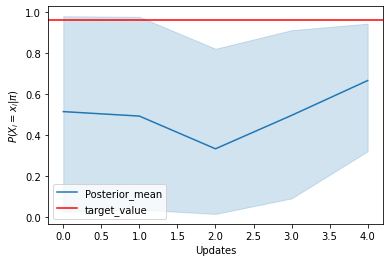

In [37]:
plotter(upd_posterior,actual_params,'Cr','No',('ACD','dolomite'),5)

Sampling weekly over a period of 5 years for each one of the 200 pipes

In [ ]:
##### Using the functions to get plots
#Example plot for Lk=negative with parent instatiation (Cr=No,Df=False,Dg=No) for the first 100 updates
plotter(upd_posterior,actual_params,'Lk','Negative',('No',False,'Yes'),399)
#plt.savefig('test.png', dpi=400)

In [38]:
def plot_node_params(node_name,child_value_mapping,parent_config_mapping):
    for child_value in child_value_mapping[node_name].keys():
        for parent_configs in parent_config_mapping[node_name].keys():
            plotter(upd_posterior,actual_params,node_name,child_value,parent_configs,260)
        
        

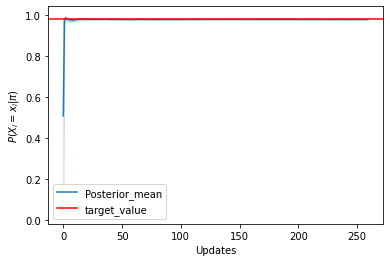

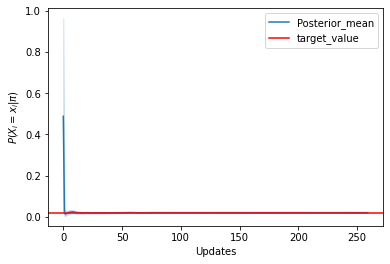

In [47]:
# Plot by node name
plot_node_params('Df',child_value_mapping,parent_config_mapping)

## Model evaluation

In [48]:
def posterior_model_generator(post_parameters,update_point,n=10):
    """This function builds a Bayesian network model based on the mean of the n-sample values of the parameters, sampled
     from the corresponding posterior Dirichlet distributions
       
       Returns a fully defined BN model as of the update point of interest
       
       """
    # Defining model structure
    model = BayesianModel([('St', 'Cr'), ('Mt', 'Cr'), ('Di', 'Dg'), ('Lo', 'Sn'), 
                           ('Sn', 'Dg'), ('Dg', 'Lk'),('Cr', 'Lk'), ('Df', 'Lk')])
    St = np.mean(multiple_sample_intrim('St',post_parameters,update_point,n)[update_point,:,:,:],axis=0)
    Lo = np.mean(multiple_sample_intrim('Lo',post_parameters,update_point,n)[update_point,:,:,:],axis=0)
    Df = np.mean(multiple_sample_intrim('Df',post_parameters,update_point,n)[update_point,:,:,:],axis=0)
    Mt = np.mean(multiple_sample_intrim('Mt',post_parameters,update_point,n)[update_point,:,:,:],axis=0)
    Di = np.mean(multiple_sample_intrim('Di',post_parameters,update_point,n)[update_point,:,:,:],axis=0)
    Sn = np.mean(multiple_sample_intrim('Sn',post_parameters,update_point,n)[update_point,:,:,:],axis=0)
    Cr = np.mean(multiple_sample_intrim('Cr',post_parameters,update_point,n)[update_point,:,:,:],axis=0)
    Dg = np.mean(multiple_sample_intrim('Dg',post_parameters,update_point,n)[update_point,:,:,:],axis=0)
    Lk = np.mean(multiple_sample_intrim('Lk',post_parameters,update_point,n)[update_point,:,:,:],axis=0)
    
    
    #cpd_Df = TabularCPD(variable='Df', variable_card=2, values= Df)
    cpd_St = TabularCPD(variable='St', variable_card=2, values= St)
    cpd_Lo = TabularCPD(variable='Lo', variable_card=2, values= Lo)
    cpd_Df = TabularCPD(variable='Df', variable_card=2, values= Df)
    cpd_Mt = TabularCPD(variable='Mt', variable_card=4, values= Mt)
    cpd_Di = TabularCPD(variable='Di', variable_card=3, values= Di)
    #cpd_Lo = TabularCPD(variable='Lo', variable_card=2, values= Lo)
    #cpd_Df = TabularCPD(variable='Df', variable_card=2, values= Df)

    cpd_Sn = TabularCPD(variable='Sn', variable_card=3, 
                       values= Sn,                          
                      evidence=['Lo'],
                      evidence_card=[2])

    cpd_Cr = TabularCPD(variable='Cr', variable_card=2, 
                       values=Cr,                          
                      evidence=['Mt','St'],
                      evidence_card=[4, 2])

    cpd_Dg = TabularCPD(variable='Dg', variable_card=2, 
                       values=Dg,                          
                      evidence=['Di','Sn'],
                      evidence_card=[3, 3])
    cpd_Lk = TabularCPD(variable='Lk', variable_card=2, 
                       values=Lk,                          
                      evidence=['Cr','Df','Dg'],
                      evidence_card=[2, 2, 2])
    model.add_cpds(cpd_St, cpd_Mt, cpd_Di, cpd_Lo, cpd_Sn, cpd_Df, cpd_Cr, cpd_Dg, cpd_Lk)
    if model.check_model() == True:
        return model
    else:
        return "Sorry! Something went wrong"

In [49]:
test1 = pd.read_csv('test_small_samp2.csv').drop('Unnamed: 0',axis =1)

In [ ]:
def predict_probabilities(test,inference):
    pred_prob = np.zeros((len(test),2))
    for i in range(len(test)):
        evidence = {}
        for column in test.columns[:-1]:
            evidence.update({column:child_value_mapping[column][test[column].iloc[i]]})
        #print(yu)
        result = inference.query(variables=[test.columns[-1]],evidence = evidence)
        pred_prob[i,0] = result.values[0]
        pred_prob[i,1] = result.values[1]
    return pred_prob

In [ ]:
bn_model = posterior_model_generator(upd_posterior,20,n=1000) # Sampled model parameters from posterior Dirichlet
inference = VariableElimination(bn_model)

In [ ]:
pr_pb = predict_probabilities(test1,inference)

In [ ]:
x = test1['Lk'].values

In [ ]:
# evaluation and Mathews correlation coefficient for every model parameter update
Mcc_progressive_model_updates = []
for i in range(5):
    bn_model = posterior_model_generator(upd_posterior,i,n=1000) # Sampled model parameters from posterior Dirichlet
    inference = VariableElimination(bn_model) # Defining inference (set up for performing variable elimination)
    pred_prob = predict_probabilities(test1,inference) #Obtaining prediction probability given the testset
    leak_prediction = [child_value_mapping_reversed['Lk'][np.argmax(pred_prob[k])] for k in range(pred_prob.shape[0])] # leak status prediction
    y_true = test1['Lk']
    Mcc_progressive_model_updates.append(matthews_corrcoef(y_true, leak_prediction))
    

In [ ]:
# evaluation and Mathews correlation coefficient for every model parameter update
Mcc_progressive_model_updates_lower_db = []
for i in range(250):
    bn_model = posterior_model_generator(upd_posterior,i,n=1000) # Sampled model parameters from posterior Dirichlet
    inference = VariableElimination(bn_model) # Defining inference (set up for performing variable elimination)
    pred_prob = predict_probabilities(test1,inference) #Obtaining prediction probability given the testset
    predict = [0 if pred_prob[i,1]<0.45 else 1 for i in range(len(pred_prob))]
    leak_prediction = [child_value_mapping_reversed['Lk'][k] for k in predict] # leak status prediction
    y_true = test1['Lk']
    Mcc_progressive_model_updates_lower_db.append(matthews_corrcoef(y_true, leak_prediction))
    

In [ ]:
# evaluation and Mathews correlation coefficient for every model parameter update
Mcc_progressive_model_updates_lower_dbt = []
for i in range(100):
    bn_model = posterior_model_generator(upd_posterior,i,n=1000) # Sampled model parameters from posterior Dirichlet
    inference = VariableElimination(bn_model) # Defining inference (set up for performing variable elimination)
    pred_prob = predict_probabilities(test1,inference) #Obtaining prediction probability given the testset
    predict = [0 if pred_prob[i,1]<0.475 else 1 for i in range(len(pred_prob))]
    leak_prediction = [child_value_mapping_reversed['Lk'][k] for k in predict] # leak status prediction
    y_true = test1['Lk']
    Mcc_progressive_model_updates_lower_dbt.append(matthews_corrcoef(y_true, leak_prediction))
    

In [ ]:
Mcc_progressive_model_updates_lower_dbt

In [ ]:
cleaned = np.array(Mcc_progressive_model_updates_lower_db)
cleaned = cleaned[cleaned < 0.573]

In [ ]:
plt.plot(cleaned)

In [ ]:
plt.plot(cleaned)
plt.ylabel('MCC')
plt.xlabel('Updates')
plt.title('MCC for each model update')

In [ ]:
bn_model = posterior_model_generator(upd_posterior,2,n=10) # Sampled model parameters from posterior Dirichlet
inference = VariableElimination(bn_model) # Defining inference (set up for performing variable elimination)
pred_prob = predict_probabilities(test.head(100),inference) #Obtaining prediction probability given the testset
leak_prediction = [child_value_mapping_reversed['Lk'][np.argmax(pred_prob[i])] for i in range(pred_prob.shape[0])] # leak status prediction
y_true = test.head(100)['Lk']
#y_pred = pipe_leak_status


In [ ]:
matthews_corrcoef

## Function for computing posterior predictive distribution for pipe leak status. Accounting for uncertanity from parameters

In [ ]:
def leak_status_predictive_distribution(posterior_parameter,evidence,n):
    """This function samples the posterior predictive distribution for pipe leak status given the observed 
       evidence on a pipe on which the prediction is desired. This is done by iteravely perfoming variable 
       elimination and making predicitions based on the observed evidence while picking varying sample 
       parameter values from the updated posterior distribution for each iteration. 
       Input:  posterior_parameter =  Updated posterior parameters (passed in as dictionary with all update history)
               evidence = Observed evidence on pipe of interest (passed as dictionary)
               "example:{'St':1,'Mt':2, 'Di':0, 'Lo':0,'Sn':0,'Df':0,'Dg':0}"
               n = desired sample size for the predictive distribution"""
    #n = 1000
    predictive_distribution = []
    inf_post = np.zeros((2,n))
    for i in range(n):
        # Defining single sample of cpds
        St = cpt_sampler('St',posterior_parameter)
        Mt = cpt_sampler('Mt',posterior_parameter)
        Di = cpt_sampler('Di',posterior_parameter)
        Lo = cpt_sampler('Lo',posterior_parameter)
        Df = cpt_sampler('Df',posterior_parameter)
        Sn = cpt_sampler('Sn',posterior_parameter)
        Cr = cpt_sampler('Cr',posterior_parameter)
        Dg = cpt_sampler('Dg',posterior_parameter)
        Lk = cpt_sampler('Lk',posterior_parameter)    
        # Defining individual CPDs.
        # The defined probabilities have to be difined as variables that are to be updated at every iteration

        cpd_St = TabularCPD(variable='St', variable_card=2, values= St)
        cpd_Lo = TabularCPD(variable='Lo', variable_card=2, values= Lo)
        cpd_Df = TabularCPD(variable='Df', variable_card=2, values= Df)
        cpd_Mt = TabularCPD(variable='Mt', variable_card=4, values= Mt)
        cpd_Di = TabularCPD(variable='Di', variable_card=3, values= Di)


        cpd_Sn = TabularCPD(variable='Sn', variable_card=3, 
                           values= Sn,                          
                          evidence=['Lo'],
                          evidence_card=[2])

        cpd_Cr = TabularCPD(variable='Cr', variable_card=2, 
                           values=Cr,                          
                          evidence=['Mt','St'],
                          evidence_card=[4, 2])

        cpd_Dg = TabularCPD(variable='Dg', variable_card=2, 
                           values=Dg,                          
                          evidence=['Di','Sn'],
                          evidence_card=[3, 3])
        cpd_Lk = TabularCPD(variable='Lk', variable_card=2, 
                           values=Lk,                          
                          evidence=['Cr', 'Df','Dg'],
                          evidence_card=[2, 2, 2])
        model1.add_cpds(cpd_St, cpd_Mt, cpd_Di, cpd_Lo, cpd_Sn, cpd_Df, cpd_Cr, cpd_Dg, cpd_Lk)
        model1.check_model()
        inference = VariableElimination(model1)
        result = inference.query(variables=['Lk'], evidence=evidence)
        inf_post[0,i] = result.values[0]
        inf_post[1,i] = result.values[1]
        predictive_distribution.append(np.random.binomial(1,result.values[1]))
    pred_dist = Counter(predictive_distribution)
    return(pred_dist)   
    

In [ ]:
def num_evidence(observ):
    '''returns numerical values coresponding to the qualitative descriptions of observed values
    input: Observed evidence =  list with on the values in the order of the columns in the test dataset
    Lk,Mt,Di,Lo,Cr,Sn,Df,Dg'''
    return {'St':child_value_mapping['St'][observ[0]],'Mt':child_value_mapping['Mt'][observ[1]],
            'Di':child_value_mapping['Di'][observ[2]],'Lo':child_value_mapping['Lo'][observ[3]],
            'Cr':child_value_mapping['Cr'][observ[4]],'Sn':child_value_mapping['Sn'][observ[5]],
            'Df':child_value_mapping['Df'][observ[6]],'Dg':child_value_mapping['Dg'][observ[7]]}

In [ ]:
pr_pb[22,:]

In [ ]:
testing = ['regular','steel','Small','Exit','Yes','High',True,'Yes']

In [ ]:
test1[test1['Lk'] == 'Positive']

In [ ]:
#evidence1 = {'St':1,'Mt':2, 'Di':0, 'Lo':0,'Sn':0,'Df':0,'Dg':0} # Lk(0) = negative , Lk(1) = positive
# Looking through the posterior predictive intervals corresponding to predictions based on test set.
frm_test_set = list(test1.loc[22])
evidence1 = num_evidence(frm_test_set[0:-1])
post_pred_ev1 = leak_status_predictive_distribution(upd_posterior,evidence1,1000)

In [ ]:
# plotting posterior predictive
pred_lk_E = post_pred_ev1
k = frm_test_set#[0:-1]
kiu = list(evidence1.keys())

#import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Negative', 'Positive']#, 'Java', 'Python', 'PHP']
students = [pred_lk_E[0],pred_lk_E[1]]
ax.bar(langs,students)
#plt.title(f'Posterior predictive distribution for pipe leak status given \n {kiu[0]}={k[0]}, {kiu[1]}={k[1]},{kiu[2]}={k[2]},{kiu[3]}={k[3]}\n {kiu[4]}={k[4]}, {kiu[5]}={k[5]},{kiu[6]}={k[6]},{kiu[7]}={k[7]}')
plt.ylabel('counts')
plt.show()
print(f'Posterior predictive distribution for pipe leak status given \n {kiu[0]}={k[0]}, {kiu[1]}={k[1]},{kiu[2]}={k[2]},{kiu[3]}={k[3]}\n {kiu[4]}={k[4]}, {kiu[5]}={k[5]},{kiu[6]}={k[6]},{kiu[7]}={k[7]}')

In [ ]:
# pipe leak predic

In [ ]:
child_value_mapping

In [ ]:
post_pred_ev1

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Negative', 'Positive']#, 'Java', 'Python', 'PHP']
students = [pred_lk_E[0],pred_lk_E[1]]
ax.bar(langs,students)
plt.ylabel('counts')
plt.show()

In [ ]:
k = list(test1.loc[3])[0:-1]
kiu = list(evidence1.keys())

for i in range(len(k)):
    print(f'{kiu[i]}={k[i]}')

In [ ]:
# Computing posterior distributions after inference
n = 1000
predictive_distribution = []
inf_post = np.zeros((2,n))
for i in range(n):
    # Defining single sample of cpds
    St = cpt_sampler('St',upd_posterior)
    Mt = cpt_sampler('Mt',upd_posterior)
    Di = cpt_sampler('Di',upd_posterior)
    Lo = cpt_sampler('Lo',upd_posterior)
    Df = cpt_sampler('Df',upd_posterior)
    Sn = cpt_sampler('Sn',upd_posterior)
    Cr = cpt_sampler('Cr',upd_posterior)
    Dg = cpt_sampler('Dg',upd_posterior)
    Lk = cpt_sampler('Lk',upd_posterior)    
    # Defining individual CPDs.
    # The defined probabilities have to be difined as variables that are to be updated at every iteration

    cpd_St = TabularCPD(variable='St', variable_card=2, values= St)
    cpd_Lo = TabularCPD(variable='Lo', variable_card=2, values= Lo)
    cpd_Df = TabularCPD(variable='Df', variable_card=2, values= Df)
    cpd_Mt = TabularCPD(variable='Mt', variable_card=4, values= Mt)
    cpd_Di = TabularCPD(variable='Di', variable_card=3, values= Di)
    #cpd_Lo = TabularCPD(variable='Lo', variable_card=2, values= Lo)
    #cpd_Df = TabularCPD(variable='Df', variable_card=2, values= Df)

    cpd_Sn = TabularCPD(variable='Sn', variable_card=3, 
                       values= Sn,                          
                      evidence=['Lo'],
                      evidence_card=[2])

    cpd_Cr = TabularCPD(variable='Cr', variable_card=2, 
                       values=Cr,                          
                      evidence=['Mt','St'],
                      evidence_card=[4, 2])

    cpd_Dg = TabularCPD(variable='Dg', variable_card=2, 
                       values=Dg,                          
                      evidence=['Di','Sn'],
                      evidence_card=[3, 3])
    cpd_Lk = TabularCPD(variable='Lk', variable_card=2, 
                       values=Lk,                          
                      evidence=['Cr', 'Df','Dg'],
                      evidence_card=[2, 2, 2])
    model1.add_cpds(cpd_St, cpd_Mt, cpd_Di, cpd_Lo, cpd_Sn, cpd_Df, cpd_Cr, cpd_Dg, cpd_Lk)
    model1.check_model()
    inference = VariableElimination(model1)
    evidence = {'St':1,'Mt':2, 'Di':0, 'Lo':0,'Sn':0,'Df':0,'Dg':0} # Lk(0) = negative , Lk(1) = positive
    result = inference.query(variables=['Lk'], evidence=evidence)
    inf_post[0,i] = result.values[0]
    inf_post[1,i] = result.values[1]
    predictive_distribution.append(np.random.binomial(1,result.values[1]))
#print(predictive_distribution)

In [ ]:
pred_lk_E = Counter(predictive_distribution)


#import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Negative', 'Positive']#, 'Java', 'Python', 'PHP']
students = [pred_lk_E[0],pred_lk_E[1]]
ax.bar(langs,students)
plt.ylabel('counts')
plt.show()

In [ ]:
np.random.binomial(1,0.5)

In [ ]:
inf_post[]

In [ ]:
bn_model = posterior_model_generator(upd_posterior,5,n=1000) # Sampled model parameters from posterior Dirichlet
inference = VariableElimination(bn_model)

In [ ]:
pred_prob = predict_probabilities(test.head(200),inference)
leak_prediction = [child_value_mapping_reversed['Lk'][np.argmax(pred_prob[i])] for i in range(pred_prob.shape[0])]
#np.argmax(pred_prob[0])
#leak_prediction

In [ ]:
y_pred

In [ ]:

y_true = test['Lk'].head(200)
y_pred = leak_prediction
matthews_corrcoef(y_true, y_pred)

In [ ]:
test['Lk'].head(5)

In [ ]:
pred_prob = np.zeros((len(test_set.head(10)),2))
for i in range(len(test_set.head(10))):
    yu = {}
    for column in test_set.columns:
        yu.update({column:child_value_mapping[column][test_set[column].iloc[i]]})
    #print(yu)
    result = inference.query(variables=['Lk'],evidence=yu)
    pred_prob[i,1] = result.values[0]
    pred_prob[i,0] = result.values[1]

In [ ]:
post_model = posterior_model_generator(upd_posterior,0,n=1000)

In [ ]:
# predicting labels
y_pred = post_model.predict(X_test)

In [ ]:
post_model.get_cpds('Lk').values

In [ ]:
y_true = test['Lk'] # Known target

In [ ]:
X_test = test.drop('Lk', axis = 1) # 
#X_test = X_test.values

In [ ]:
# predicting labels
y_pred = post_model.predict(X_test)

In [ ]:
#Predicting probabilities
y_pred_prod = post_model.predict_probability(X_test)

In [ ]:
# getting predicted probabilities for the positive class
pos_pred_prob = y_pred_prod['Lk_Positive'].values
# calculating metric precision recall metric
lr_f1, lr_auc = f1_score(y_true, y_pred,pos_label='Positive'), auc(lr_recall, lr_precision)

In [ ]:
# Evaluation per update.
def model_evaluation_per_update(test,model_for_evaluation):
    """ evaluating every potential model from Dirichlet parameters"""
    # Splitting independent from dependent variables
    #test.columnss
    y_true = test['Lk'] # Known target
    X_test = test.drop('Lk', axis = 1) # 

    # predicting labels
    y_pred = model_for_evaluation.predict(X_test)

    #Predicting probabilities
    y_pred_prod = model_for_evaluation.predict_probability(X_test)

    # getting predicted probabilities for the positive class
    pos_pred_prob = y_pred_prod['Lk_Positive'].values
    # calculating metric precision recall metric
    lr_f1, lr_auc = f1_score(y_true, y_pred,pos_label='Positive'), auc(lr_recall, lr_precision)
    # summarize scores
    Return(lr_f1, lr_auc)#('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))


In [ ]:
#test.values

In [ ]:
# pr_auc close to 1 is what we'd hope for pr_auc close to 0.5 model has no skill 
model_test = posterior_model_generator(upd_posterior,0,n=100)
pr_auc = model_evaluation_per_update(test,model_test)

In [ ]:
# Importing test data
test = pd.read_csv('test_wdssimulated_data.csv').drop('Unnamed: 0', axis = 1)

In [ ]:
# Splitting independent from dependent variables
#test.columnss
y_true = test['Lk'] # Known target
X_test = test.drop('Lk', axis = 1) # 
X_test 
# predicting labels
y_pred = model_structure.predict(X_test)

#Predicting probabilities
y_pred_prod = model_structure.predict_probability(X_test)

# getting predicted probabilities for the positive class
pos_pred_prob = y_pred_prod['Lk_Positive'].values

In [ ]:
# Due to class imbalance with very few samples for the positive class, one useful metric is the precision-recall metric
# Which measures how well the model is performing only on the positive class
# calculate precision-recall curve
lr_precision, lr_recall, thresholds = precision_recall_curve(y_true, pos_pred_prob,pos_label='Positive')

In [ ]:
lr_f1, lr_auc = f1_score(y_true, y_pred,pos_label='Positive'), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

In [ ]:
# F1 Score
# calculate F1 score
f1 = f1_score(y_true, y_pred,pos_label='Positive')

In [ ]:
# calculate precision-recall AUC
PR_auc = auc(recall, precision)

In [ ]:
#from matplotlib import pyplot
lr_precision, lr_recall, _ = precision_recall_curve(y_true, pos_pred_prob,pos_label='Positive')
lr_f1, lr_auc = f1_score(y_true, y_pred,pos_label='Positive'), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_true[y_true==1]) / len(y_true)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# ROC plot(FPR vs TPR )
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, pos_pred_prob,pos_label='Positive')

# calculate AUC score
ROC_auc = roc_auc_score(y_true, pos_pred_prob)#,#pos_label='Positive')
print('AUC: %.3f' % ROC_auc)

# Model skills are good enough.

# calculate scores
ns_probs = [0 for _ in range(len(y_true))]
ns_auc = roc_auc_score(y_true, ns_probs)
lr_auc = roc_auc_score(y_true, pos_pred_prob)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs,pos_label='Positive')
lr_fpr, lr_tpr, _ = roc_curve(y_true, pos_pred_prob,pos_label='Positive')
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
model_updated()

In [ ]:
# specify parameter dictionary with all parameters Dirichlet prior parameters
def dir_sampler(upd_posterior,node_name = 'St', n = 1000):
    '''sampling from posterior distribution for the whole cpt each parameter with n samples
    Input: 
    Dir_params = an array of shape (updates,k,n,l)
    n = number of samples to be generated for each cpd
    k = dimension of cpd "possible joint over parents possible outcomes" k=1 for rootnode.
    l = possible outcomes of child node   
    Output:
    ndarray containing posterior's for each parameter, each with n samples
    '''
    post_dir = upd_posterior[0][node_name]
    #n = 1000
    cpt_param_upd = np.zeros((len(upd_posterior.keys()),post_dir.shape[1],n,post_dir.shape[0]))
    for j in range(len(upd_posterior.keys())): # looping over the update moments
        post_dir_params = upd_posterior[j][node_name]
        cpt_lk = np.zeros((post_dir_params.shape[1], n ,post_dir_params.shape[0])) #dim3
        st = post_dir_params.T
        for i in range(st.shape[0]):
            cpt_lk[i] = np.random.dirichlet(st[i].flatten(), n) #Generating n random samples for  multinomial over parents instatiation
        cpt_param_upd[j] = cpt_lk    
    return np.around(cpt_param_upd, decimals=3)

In [ ]:
# input from function above
def plot(cpt_param_upd,child_instatiation = 0,Parent_instatiation = 0):
    #child_instatiation = 0 # You can adjust child instatiations (0=neg,1=pos)
    #Parent_instatiation = 7 # Different joint parent instatiations
    Lb = [np.percentile(cpt_param_upd[i,Parent_instatiation,:,child_instatiation], 2.5) for i in range(cpt_param_upd.shape[0])]
    Ub = [np.percentile(cpt_param_upd[i,Parent_instatiation,:,child_instatiation], 97.5) for i in range(cpt_param_upd.shape[0])]
    x = [i for i in range(cpt_param_upd.shape[0])]
    plt.fill_between(x, Lb, Ub, alpha=0.2, color='tab:blue')
    plt.plot([cpt_param_upd[i,Parent_instatiation,:,child_instatiation].mean() for i in range(cpt_param_upd.shape[0])],label = 'parameter_evolution')

In [ ]:
# import the simulated data (Simulated in R see link to the simulation code in R) with these variables

df = pd.read_csv('wdssimulated_data.csv', index_col= None).drop(columns = 'Unnamed: 0')

In [ ]:
# Data exploration for class balance analysis
df.shape

In [ ]:
#print(df.head().to_latex(index=False))  

In [ ]:
df1 = df.head(1000)

In [ ]:
#len(target[:100])

In [ ]:
# Numerical transformation for the purpose of resampling using smote

In [ ]:
#df1.head()

In [ ]:
child_value_mapping = {'St': {'dolomite':0, 'regular':1},
 'Cr': {'No':0, 'Yes':1},
 'Mt': {'ACD':0, 'HDPE':1, 'steel':2, 'Upvc':3},
 'Di': {'Small':0, 'Medium':1, 'Large':2},
 'Dg': {'No':0 ,'Yes': 1},
 'Sn': {'NoStrain':0, 'Low':1, 'High':2},
 'Lo': {'Erf':0, 'Exit':1},
 'Lk': {'Negative': 0, 'Positive': 1},
 'Df': {False : 0,  True : 1}}

In [ ]:
child_value_mapping_reversed = {'St': {0:'dolomite', 1:'regular'},
 'Cr': {0: 'No', 1: 'Yes'},
 'Mt': {0: 'ACD', 1: 'HDPE', 2: 'steel', 3: 'Upvc'},
 'Di': {0: 'Small', 1: 'Medium', 2: 'Large'},
 'Dg': {0: 'No' , 1: 'Yes'},
 'Sn': {0: 'NoStrain', 1: 'Low',2: 'High'},
 'Lo': {0: 'Erf', 1: 'Exit'},
 'Lk': {0: 'Negative', 1: 'Positive'},
 'Df': {0: False , 1: True }}

In [ ]:
# From text to numeric for the purpose of facilitating SMOTE resampling
X_num = np.zeros(df1.shape, dtype = int)
for j,col_name in enumerate(df1.columns):
    for i in range(df1.shape[0]):
        X_num[i,j] = tr[col_name][df1[col_name].loc[i]]
#k[:,-1]        

In [ ]:
# Resample for class balance
# Importing data and applying  SMOTE (synthetic minority over-sampling technique )

# Maintaining the same random numbers
seed = 100
# SMOTE number of neighbors
k = 1
#df1 = df.head(200)
X = X_num[:,:-1]
y = X_num[:,-1]
#sm = SMOTE(random_state=42, ratio = 1.0)
sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)
X_res, y_res = sm.fit_resample(X, y)

In [ ]:
# Bringing target and labels into same array
y_resrs = y_res.reshape((y_res.shape[0],1))
an_array = np.append(X_res, y_resrs, axis=1)

In [ ]:
# From numbers back to the initial string values
X_str = np.zeros(an_array.shape, dtype = object)
for j,col_name in enumerate(df1.columns):
    for i in range(an_array.shape[0]):
        X_str[i,j] = rtr[col_name][an_array[i,j]]

In [ ]:
# converting to data frame
frame = pd.DataFrame(X_str, index=[i for i in range(X_str.shape[0])], columns=df1.columns, dtype=None, copy=False)

In [ ]:
# Sampled data frame
frame.head()

In [ ]:
class_freq = Counter(frame["Lk"])
#import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Negative', 'Positive']#, 'Java', 'Python', 'PHP']
students = [class_freq['Negative'],class_freq['Positive']]
ax.bar(langs,students)
plt.show()

In [ ]:
# Defining model structure
model = BayesianModel([('St', 'Cr'), ('Mt', 'Cr'), ('Di', 'Dg'), ('Lo', 'Sn'), ('Sn', 'Dg'), ('Dg', 'Lk'),('Cr', 'Lk'), ('Df', 'Lk')])

In [ ]:
## Variable states
state_names = {'St': ("dolomite", "regular"),'Mt': ("ACD", "HDPE", "steel","Upvc"),'Cr':("No","Yes"),
               'Df':(False,True),'Lo':("Erf", "Exit"),'Sn':("NoStrain","Low","High"),'Di':("Small", "Medium", "Large"),
               'Dg':("No","Yes"),'Lk':("Negative","Positive")}

Prior_Dirparams = {'St': np.ones((2,1)),'Mt' : np.ones((4,1)), 'Cr': np.ones((2,8)),'Df': np.ones((2,1)),'Lo': np.ones((2,1)),
          'Sn':np.ones((3,2)),'Di':np.ones((3,1)),'Dg':np.ones((2,9)) ,'Lk': np.ones((2,8))}

In [ ]:
#Prior_Dirparams

# Working on the updating part

## Data based updating of BN_model

In [ ]:
#Split update points
# Splitting the main data frame into smaller batches for the updating steps
# each patch comprise approximately k data point
k = 10
data_split = np.array_split(frame, len(frame)/k)
print(len(data_split))

In [ ]:
def cpt_sampler(node,dir_post_params):
    '''Given dirichlet posterior parameters this function is for sampling node cpt parameters
    input : 
            Node for which we want to get cpt
            Posterior parameter
    Output : Sample posterior cpt parameters given the posterior dirichlet parameter 
    '''
    dim = dir_post_params[len(dir_post_params)-1][node].shape # Change 100 index such that it represents the most recent updata
    cpt_sample_post = np.zeros(dim)
    for i in range(dim[1]):
        cpt_sample_post[:,i] = np.random.dirichlet(dir_post_params[len(dir_post_params)-1][node][:,i].flatten())
    return cpt_sample_post

In [ ]:
# specify parameter dictionary with all parameters Dirichlet prior parameters
def dir_sampler(upd_posterior,node_name = 'St', n = 1000):
    '''sampling from posterior distribution for the whole cpt each parameter with n samples
    Input: 
    Dir_params = an array of shape (updates,k,n,l)
    n = number of samples to be generated for each cpd
    k = dimension of cpd "possible joint over parents possible outcomes" k=1 for rootnode.
    l = possible outcomes of child node   
    Output:
    ndarray containing posterior's for each parameter, each with n samples
    '''
    post_dir = upd_posterior[0][node_name]
    #n = 1000
    cpt_param_upd = np.zeros((len(upd_posterior.keys()),post_dir.shape[1],n,post_dir.shape[0]))
    for j in range(len(upd_posterior.keys())): # looping over the update moments
        post_dir_params = upd_posterior[j][node_name]
        cpt_lk = np.zeros((post_dir_params.shape[1], n ,post_dir_params.shape[0])) #dim3
        st = post_dir_params.T
        for i in range(st.shape[0]):
            cpt_lk[i] = np.random.dirichlet(st[i].flatten(), n) #Generating n random samples for  multinomial over parents instatiation
        cpt_param_upd[j] = cpt_lk    
    return np.around(cpt_param_upd, decimals=3)

In [ ]:
# input from function above
def plot(cpt_param_upd,child_instatiation = 0,Parent_instatiation = 0):
    #child_instatiation = 0 # You can adjust child instatiations (0=neg,1=pos)
    #Parent_instatiation = 7 # Different joint parent instatiations
    Lb = [np.percentile(cpt_param_upd[i,Parent_instatiation,:,child_instatiation], 2.5) for i in range(cpt_param_upd.shape[0])]
    Ub = [np.percentile(cpt_param_upd[i,Parent_instatiation,:,child_instatiation], 97.5) for i in range(cpt_param_upd.shape[0])]
    x = [i for i in range(cpt_param_upd.shape[0])]
    plt.fill_between(x, Lb, Ub, alpha=0.2, color='tab:blue')
    plt.plot([cpt_param_upd[i,Parent_instatiation,:,child_instatiation].mean() for i in range(cpt_param_upd.shape[0])],label = 'parameter_evolution')

In [ ]:
upd_posterior[100]['Dg']

In [ ]:
#upd_posterior[100]

In [ ]:
#post_dist_tables = [Dir_parms_st,Dir_parms_mt,Dir_parms_sn, Dir_parms_di,Dir_parms_df,Dir_parms_lo,
                    #Dir_parms_cr, Dir_parms_dg,Dir_parms_lk]

post_dist_table_names = ['St','Mt','Sn','Di','Df','Lo','Cr','Dg','Lk']
target_parameter_values=[0.078,0.057,0.36,0.546,1-0.02,0.633,0.04,0.56,1]
for i in range(len(post_dist_table_names)):
    plot(dir_sampler(upd_posterior, node_name = post_dist_table_names[i], n = 10000))
    plt.axhline(target_parameter_values[i], color="Red",label = 'target_value')
    plt.xlabel('Updates')
    plt.ylabel('$P(X_u=x_u)$')
    plt.title(f'Sample parameter posterior from {post_dist_table_names[i]}')
    plt.legend()
    plt.show()

In [ ]:
# Parameter analysis
# Is the targate parater value held in the 95 percent credible interval?

# Slice a histogram at some iteration point. We can do it for the first iteration

In [ ]:
# plot a histogram for the posterior distribution of the model parameters
post_distribution = dir_sampler(upd_posterior, node_name ='Lk', n = 1000)[0,0,:,0]
LI = np.percentile(dir_sampler(upd_posterior, node_name ='Lk', n = 1000)[0,0,:,0],2.5)
UI = np.percentile(dir_sampler(upd_posterior, node_name ='Lk', n = 1000)[0,0,:,0],97.5)
weights = np.ones_like(post_distribution)/float(len(post_distribution))
plt.hist(post_distribution, weights=weights)
plt.vlines(LI,ymin = 0 ,ymax= .4,colors='red',linestyles='dashed')
plt.vlines(UI,ymin = 0 ,ymax=.4,colors='red',linestyles='dashed')
plt.vlines(0.98,ymin = 0 ,ymax=.4,colors='red',linestyles='solid')


In [ ]:
len(dir_sampler(upd_posterior, node_name ='Lk', n = 1000))

In [ ]:
# sample posterior per node
post_dist_table_names = ['St','Mt','Sn','Di','Df','Lo','Cr','Dg','Lk']
target_parameter_values=[0.078,0.057,0.36,0.546,0.02,0.633,0.04,0.12,0.98]
for i in range(len(post_dist_table_names)):
    # plot a histogram for the posterior distribution of the model parameters
    post_distribution = dir_sampler(upd_posterior, node_name =post_dist_table_names[i], n = 1000)[1,0,:,0]
    LI = np.percentile(dir_sampler(upd_posterior, node_name =post_dist_table_names[i], n = 1000)[1,0,:,0],2.5)
    UI = np.percentile(dir_sampler(upd_posterior, node_name =post_dist_table_names[i], n = 1000)[1,0,:,0],97.5)
    weights = np.ones_like(post_distribution)/float(len(post_distribution))
    plt.hist(post_distribution, weights=weights)
    #plt.xlim(0.06,0.1)
    plt.title(f'{post_dist_table_names[i]}')
    plt.vlines(LI,ymin = 0 ,ymax= .4,colors='red',linestyles='dashed')
    plt.vlines(UI,ymin = 0 ,ymax=.4,colors='red',linestyles='dashed')
    plt.vlines(target_parameter_values[i],ymin = 0 ,ymax=.4,colors='red',linestyles='solid')
    plt.show()

In [ ]:
#Evoluiton of distribution with more observations
for i in range(len(dir_sampler(upd_posterior, node_name ='St', n = 1000))):
    # plot a histogram for the posterior distribution of the model parameters
    post_distribution = dir_sampler(upd_posterior, node_name ='St', n = 1000)[i,0,:,0]
    LI = np.percentile(dir_sampler(upd_posterior, node_name ='St', n = 1000)[i,0,:,0],2.5)
    UI = np.percentile(dir_sampler(upd_posterior, node_name ='St', n = 1000)[i,0,:,0],97.5)
    weights = np.ones_like(post_distribution)/float(len(post_distribution))
    plt.hist(post_distribution, weights=weights)
    plt.xlim(0.06,0.1)
    plt.vlines(LI,ymin = 0 ,ymax= .4,colors='red',linestyles='dashed')
    plt.vlines(UI,ymin = 0 ,ymax=.4,colors='red',linestyles='dashed')
    plt.vlines(0.078,ymin = 0 ,ymax=.4,colors='red',linestyles='solid')
    plt.show()

# Might be of use code 

# Inference in Bayesian networks

In [ ]:
#bayesNet.check_model()
#print("Model is correct."#

In [ ]:
#model.update()

In [ ]:
model.check_model()

##### Of interest in this study is the answer to the  inference  question, given what we observe on a pipe based in relation to the model variables what is the likelihood of the pipe having a leakage?
That is; $$P(Lk=Positive|St=st,Cr=cr,Mt=mt,Di=di,Dg=dg,Sn=sn,Lo=lo,Lk=lk,Df=df)$$
We use variable elimination algorithm to achieve this;

In [ ]:
# Variable Elimination solver
solver = VariableElimination(model)

In [ ]:
# Network nodes with their states for reference
solver.state_names_map

In [ ]:
##Assume a pipe with the following conditions
#St = dolomite, Mt = HDPE, Di = medium, Lo = exit,Df=False
evidence = {'St':0, 'Mt':1, 'Di':0, 'Lo':1,'Df':1,'Dg':1}
result = solver.query(variables=['Lk'], evidence=evidence)
print(result)

##  Evaluations

In [ ]:
# Simulated data
test1 = pd.read_csv('test_wdssimulated_data.csv').drop('Unnamed: 0', axis = 1)

In [ ]:
test1.head()

In [ ]:
# Importing test data
test = pd.read_csv('test_wdssimulated_data.csv').drop('Unnamed: 0', axis = 1)
#test.columns

y_true = test['Lk']

X_test = test.drop('Lk', axis = 1)

# predicting labels
y_pred = model.predict(X_test)

#Predicting probabilities
y_pred_prod = model.predict_probability(X_test)

pos_pred_prob = y_pred_prod['Lk_Positive'].values

# ROC plot(FPR vs TPR )
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, pos_pred_prob,pos_label='Positive')

# calculate AUC score
ROC_auc = roc_auc_score(y_true, pos_pred_prob)#,#pos_label='Positive')
print('AUC: %.3f' % ROC_auc)

# Model skills are good enough.

# calculate scores
ns_probs = [0 for _ in range(len(y_true))]
ns_auc = roc_auc_score(y_true, ns_probs)
lr_auc = roc_auc_score(y_true, pos_pred_prob)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs,pos_label='Positive')
lr_fpr, lr_tpr, _ = roc_curve(y_true, pos_pred_prob,pos_label='Positive')
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# Precision-recall metric
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, pos_pred_prob,pos_label='Positive')

recall

# F1 Score
# calculate F1 score
f1 = f1_score(y_true, y_pred,pos_label='Positive')

# calculate precision-recall AUC
PR_auc = auc(recall, precision)

#from matplotlib import pyplot
lr_precision, lr_recall, _ = precision_recall_curve(y_true, pos_pred_prob,pos_label='Positive')
lr_f1, lr_auc = f1_score(y_true, y_pred,pos_label='Positive'), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_true[y_true==1]) / len(y_true)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
con_matrix = confusion_matrix(y_true, y_pred)# Accuracy
con_matrix

In [ ]:
Accuracy = accuracy_score(y_true, y_pred)
#Accuracy

In [ ]:
recall = recall_score(y_true, y_pred, average=None)
recall

In [ ]:
precision = precision_score(y_true, y_pred, average=None)
precision

## How sensitive are our inferences to changes in node values?

In [ ]:
# Sensitivity analysis using odds ratio. 
#To assess the possible impacts of changing a node variables value to check how each single variable affects the probability
# of observing a leakage event. Helping to get a sense of how each node can independently affect the probability of a 
# leak event.
# We compute the odds of a leak based on each value instantiation of each dependent variable.
# We then take the difference between the maximum and minimum Odds from all possible node values giving a range of 
#the change in the Odds of observing a leak event. The bigger the change the more sensitive leak probabilities are to 
#that node.

In [ ]:
#Must be moved to functions
def odds_compute(solver,target_variable_name):
    ''' Input :
            Solver =  a variable elimination object defined on a fully defined Bayesian network
            target_variable_name = the name of the node for which you want to check the impacts of every other single node
        Output: 
            dictionary whose keys are network nodes and values are 2d lists containing node value name and corresponding
            Odds ratio for the occurence of a leak event if the node where in that state holding all other nodes equal'''
    tst = solver.state_names_map
    odds_dict = dict()
    for node in (set(tst.keys()) - {target_variable_name}):
        col = []
        for i in range(len(tst[node].keys())):
            result = solver.query(variables=[target_variable_name], evidence={node:i})
            #result = solver.query(variables=['Lk'], evidence={'Dg':i})
            odds = result.values[0]/(1-result.values[0])
            col.append([node,tst[node][i],odds])
        odds_dict.update({node:col})
    return odds_dict

In [ ]:
odds_dict = odds_compute(solver,'Lk')

In [ ]:
odds_dict.keys()

In [ ]:
def odds_change_range(solver,target_variable_name):    
    odds_dict = odds_compute(solver,target_variable_name)
    frame = []
    for node in odds_dict.keys():  
        lst = odds_dict[node]
        frame.append(pd.DataFrame(lst, columns =['Node','Value', 'Odds'],dtype = float))  
    Odds_sensitivity = pd.concat(frame)
    Odds_max = Odds_sensitivity.groupby(['Node']).max()
    Odds_max = Odds_max.rename(columns={'Odds':'Max_Odds'})
    Odds_min = Odds_sensitivity.groupby(['Node']).min()
    Odds_min = Odds_min.rename(columns={'Odds':'Min_Odds'}).drop('Value',axis = 1)
    min_max = pd.concat([Odds_max, Odds_min], axis=1, join='inner')
    min_max['Odds_diff'] = min_max['Max_Odds'] - min_max['Min_Odds']
    return min_max

In [ ]:
target_odds_change = odds_change_range(solver,'Lk')

In [ ]:
# The larger the difference the more sensitive Lk is to the change of values in that node under variable elimination 
# framework

target_odds_change

## Posterior predictive distribution


$P(Lk = s|D) = \frac{\alpha '_{s}}{\sum_{j=1}^{k} \alpha '_{j}}$

In [ ]:
alpha_pos = sum(Prior_Dirparams['Lk'][0])

In [ ]:
alpha_neg = sum(Prior_Dirparams['Lk'][1])

In [ ]:
post_pred = [alpha_pos/(alpha_pos+alpha_neg),alpha_neg/(alpha_pos+alpha_neg)]

In [ ]:
post_pred 

In [ ]:
# Error on the posterior prediction distribution
sigma_post_pred = post_pred[0]*post_pred[1]

In [ ]:
sigma_post_pred

# Posterior predictive distribution on query posterior 

In [ ]:
# Defining the model structure. We can define the network by just passing a list of edges.
model1 = BayesianModel([('St', 'Cr'), ('Mt', 'Cr'), ('Di', 'Dg'), ('Lo', 'Sn'), ('Sn', 'Dg'), ('Cr', 'Lk'), ('Dg', 'Lk'), ('Df', 'Lk')])


In [ ]:
def cpt_sampler(node,dir_post_params):
    '''Given dirichlet posterior parameters this function is for sampling node cpt parameter values 
       Give me a cpt Dirichelet parameters, I'll give you back a cpt containing 1 sample parameter for each multinomial
       parameter of the cpt.
    input : 
            Node for which we want to get cpt
            Posterior parameter
    Output : Sample posterior cpt parameters given the posterior dirichlet parameter 
    '''
    dim = dir_post_params[len(dir_post_params)-1][node].shape 
    cpt_sample_post = np.zeros(dim)
    for i in range(dim[1]):
        cpt_sample_post[:,i] = np.random.dirichlet(dir_post_params[len(dir_post_params)-1][node][:,i].flatten())
    return cpt_sample_post

In [ ]:
def state_marg(node,dir_post_params):
    '''Given dirichlet posterior parameters this function is for sampling node cpt parameters
    input : 
            Node for which we want to get cpt
            Posterior parameter
    Output : Sample posterior cpt parameters given the posterior dirichlet parameter 
    '''
    dim = dir_post_params[len(dir_post_params)-1][node].shape # Change 100 index such that it represents the most recent updata
    marg_counts = np.zeros(dim)
    for i in range(dim[1]):
        marg_counts[:,i] = dir_post_params[len(dir_post_params)-1][node][:,i].flatten()
    return marg_counts.sum(axis=1)

In [ ]:
state_marg('Lk',upd_posterior)

In [ ]:
# Computing posterior distributions after inference
n = 1000
inf_post = np.zeros((2,n))
for i in range(n):
    # Defining single sample of cpds
    St = cpt_sampler('St',upd_posterior)
    Mt = cpt_sampler('Mt',upd_posterior)
    Di = cpt_sampler('Di',upd_posterior)
    Lo = cpt_sampler('Lo',upd_posterior)
    Df = cpt_sampler('Df',upd_posterior)
    Sn = cpt_sampler('Sn',upd_posterior)
    Cr = cpt_sampler('Cr',upd_posterior)
    Dg = cpt_sampler('Dg',upd_posterior)
    Lk = cpt_sampler('Lk',upd_posterior)    
    # Defining individual CPDs.
    # The defined probabilities have to be difined as variables that are to be updated at every iteration

    cpd_St = TabularCPD(variable='St', variable_card=2, values= St)
    cpd_Lo = TabularCPD(variable='Lo', variable_card=2, values= Lo)
    cpd_Df = TabularCPD(variable='Df', variable_card=2, values= Df)
    cpd_Mt = TabularCPD(variable='Mt', variable_card=4, values= Mt)
    cpd_Di = TabularCPD(variable='Di', variable_card=3, values= Di)
    #cpd_Lo = TabularCPD(variable='Lo', variable_card=2, values= Lo)
    #cpd_Df = TabularCPD(variable='Df', variable_card=2, values= Df)

    cpd_Sn = TabularCPD(variable='Sn', variable_card=3, 
                       values= Sn,                          
                      evidence=['Lo'],
                      evidence_card=[2])

    cpd_Cr = TabularCPD(variable='Cr', variable_card=2, 
                       values=Cr,                          
                      evidence=['Mt','St'],
                      evidence_card=[4, 2])

    cpd_Dg = TabularCPD(variable='Dg', variable_card=2, 
                       values=Dg,                          
                      evidence=['Di','Sn'],
                      evidence_card=[3, 3])
    cpd_Lk = TabularCPD(variable='Lk', variable_card=2, 
                       values=Lk,                          
                      evidence=['Cr', 'Df','Dg'],
                      evidence_card=[2, 2, 2])
    model1.add_cpds(cpd_St, cpd_Mt, cpd_Di, cpd_Lo, cpd_Sn, cpd_Df, cpd_Cr, cpd_Dg, cpd_Lk)
    model1.check_model()
    inference = VariableElimination(model1)
    evidence = {'St':1,'Mt':2, 'Di':0, 'Lo':0,'Sn':0,'Df':0,'Dg':0} # Lk(0) = negative , Lk(1) = positive
    result = inference.query(variables=['Lk'], evidence=evidence)
    inf_post[0,i] = result.values[0]
    inf_post[1,i] = result.values[1]
print(inf_post)

## Posterior predictive in this case will be the  expected value of posterior distribution

In [ ]:
np.mean(inf_post[1])

In [ ]:
child_value_mapping

In [ ]:
test1.head()

In [ ]:
pr_pb

In [ ]:
plt.hist(inf_post[0])

In [ ]:
np.mean(inf_post[1])

In [ ]:
np.mean(inf_post[1])* (1-np.mean(inf_post[1]))

In [ ]:
sum(state_marg('Lk',upd_posterior))

In [ ]:
# Binormial likelihood function for computing posterior probability
sx = state_marg('Lk',upd_posterior)[1]
L = [(theta**sx)*((1-theta)**(sum(state_marg('Lk',upd_posterior))-sx)) for theta in inf_post[0]] 

In [ ]:
lL = [(np.log(theta)*sx)+(np.log(1-theta)*(sum(state_marg('Lk',upd_posterior))-sx)) for theta in inf_post[0]] 

In [ ]:
plt.hist(lL)

In [ ]:
plt.hist(inf_post[0]*L)#  orientation='horizontal')

In [ ]:
post_pred_tst = inf_post * L

In [ ]:
post_pred_ts = inf_post[0] * L

In [ ]:
post_pred_tst

In [ ]:
post_pred_tst[0] + post_pred_tst[1]

In [ ]:
estimator.state_counts('Df')

In [ ]:
# Mapping parent node configurations
parent_config_mapping = {"Cr":{('ACD','dolomite'):0, ('ACD','regular'):1,
                               ('HDPE','dolomite'):2, ('HDPE','regular'):3,
                               ('steel','dolomite'):4, ('steel','regular'):5,
                               ('Upvc','dolomite'):6, ('Upvc','regular'):7},
                        "Lk": {('No',False,'No'):0,('No',False,'Yes'):1, 
                               ('No',True,'No'):2,('No',True,'Yes'):3, 
                               ('Yes',False,'No'):4,('Yes',False,'Yes'):5, 
                               ('Yes',True,'No'):6,('Yes',True,'Yes'):7},
                        "Sn": {('Erf',):0,('Exit',):1},
                        "Dg": {('Small','Nostrain'):0,('Small','Low'):1,('Small','High'):2,
                              ('Medium','Nostrain'):3,('Medium','Low'):4,('Medium','High'):5,
                              ('Large','Nostrain'):6,('Large','Low'):7,('Large','High'):8},
                        'St':{None:0},
                        'Lo':{None:0},
                        'Di':{None:0},
                        'Mt':{None:0},
                        'Df':{None:0}}
#Mapping from node value to integers for arrays
child_value_mapping = {  'St': {'dolomite':0, 'regular':1},
                         'Cr': {'No':0, 'Yes':1},
                         'Mt': {'ACD':0, 'HDPE':1, 'steel':2, 'Upvc':3},
                         'Di': {'Small':0, 'Medium':1, 'Large':2},
                         'Dg': {'No':0 ,'Yes': 1},
                         'Sn': {'NoStrain':0, 'Low':1, 'High':2},
                         'Lo': {'Erf':0, 'Exit':1},
                         'Lk': {'Negative': 0, 'Positive': 1},
                         'Df': {False : 0,  True : 1}}

# True parameters
actual_params = {'Cr': np.array([[0.96,0.71,1.0,1.0,0.96,0.71,1.0,1.0],[0.04,0.29,0.0,0.0,0.04,0.29,0.0,0.0]]),
                 'Lk': np.array([[1,0.5,0.98,0.5,0.988,0.488,0.95,0.98],[0,0.5,0.02,0.5,0.012,0.512,0.05,0.02]]),
                 'Dg': np.array([[0.88, 0.84,0.36,0.973,0.88,0.48,0.975,0.92,0.56],[0.12,0.16,0.64,0.027,0.12,0.52,0.025,0.08,0.44]]),
                 'Sn': np.array([[0.36, 0.16],[0.52, 0.2],[0.12,0.64]]),
                 'St': np.array([[0.078],[0.922]]),
                 'Lo':np.array([[0.633],[0.367]]),
                 'Di':np.array([[0.546],[0.35],[0.104]]),
                 'Mt':np.array([[0.057],[0.34],[0.157],[0.446]]),
                 'Df':np.array([[0.98],[0.02]])}

In [ ]:
def tester(check_array):
    vec = []
    for i in range(check_array.shape[1]):
        vec.append(sum(check_array[:,i]))
    return vec

In [ ]:
inference = VariableElimination(model1)

In [ ]:
##Assume a pipe with the following conditions 
#St = dolomite, Mt = HDPE, Di = medium, Lo = exit,Df=False
inference = VariableElimination(model1)
evidence = {'Mt':1, 'Di':0, 'Lo':1,'Df':0,'Dg':1} # Lk(0) = negative , Lk(1) = positive
result = inference.query(variables=['Lk'], evidence=evidence)
result.values[1]
#print(result)

In [ ]:
result.values[1]

In [ ]:
def sample_cpt(node,dir_post_params,update = 0):
    '''Given dirichlet posterior parameters this function is for sampling node cpt parameters
    input : 
            node: for which we want to get cpt
            Posterior parameter
            update: the update number in reverse order. 1 implies most recent update, and total_number_of_updates is
            for the 1st update."Allow to get samples over multiple update points"
    Output : Sample posterior cpt parameters given the posterior dirichlet parameter 
    '''
    dim = dir_post_params[update][node].shape # Change 100 index such that it represents the most recent updata
    cpt_sample_post = np.zeros(dim)
    for i in range(dim[1]):
        cpt_sample_post[:,i] = np.random.dirichlet(dir_post_params[update][node][:,i].flatten())
    return cpt_sample_post

def multiple_sample(node,dir_post_params,update=1,n=1000):
    """Sampling multiple times for each cpts parameter estimate
        input : 
            node: for which we want to get cpt
            Posterior parameter
            update: the update number in reverse order. 1 implies most recent update, and max = total_number_of_updates is
            for the 1st update."Allow to get samples over multiple update points"
    Output : Sample posterior cpt parameters given the posterior dirichlet parameter 
    """
    multi_samples = np.zeros((update,n,sample_cpt(node,dir_post_params,update).shape[0],sample_cpt(node,dir_post_params,update).shape[1]))
    samples = np.zeros((n,sample_cpt(node,dir_post_params,update).shape[0],sample_cpt(node,dir_post_params,update).shape[1]))

    for j in range(update):        
        for i in range(n):
            samples[i,:,:] = sample_cpt(node,dir_post_params,j)
        multi_samples[j,:,:,:] = samples      
    return multi_samples   


In [ ]:
multiple_sample(node,dir_post_params,update=1,n=1000)

In [ ]:
post_plotter(cpt_param_upd,child_instatiation = 0,Parent_instatiation = 0)

In [ ]:
# input from function above
def post_plotter(cpt_param_upd,child_instatiation = 0,Parent_instatiation = 0):
    
    #child_instatiation = 0 # You can adjust child instatiations (0=neg,1=pos)
    #Parent_instatiation = 7 # Different joint parent instatiations
    Lb = [np.percentile(cpt_param_upd[i,:,child_instatiation,Parent_instatiation], 2.5) for i in range(cpt_param_upd.shape[0])]
    Ub = [np.percentile(cpt_param_upd[i,:,child_instatiation,Parent_instatiation], 97.5) for i in range(cpt_param_upd.shape[0])]
    x = [i for i in range(cpt_param_upd.shape[0])]
    #return Lb
    plt.fill_between(x, Lb, Ub, alpha=0.2, color='tab:blue')
    plt.plot([cpt_param_upd[i,:,child_instatiation,Parent_instatiation].mean() for i in range(cpt_param_upd.shape[0])],label = 'parameter_evolution')

#posterior_dir_params = upd_posterior
def plotter(posterior_dir_params,true_model_params, child_node, child_node_value, joint_par_config,updates = 1):
    """plotting function for orderly plots of the sampled posterior distributions
    Input: 
    Child_node: refers to node of interest which can also be a root node (in which case parent config is None)
                
    Joint_par_config: This is the cofiguration of parent node values under the cpt of the child node
                      presented as a tuple with parent values arranged alphabetically according to parents' names  """
    mapped_child_node_value = child_value_mapping[child_node][child_node_value]
    mapped_parent_node_value = parent_config_mapping[child_node][joint_par_config]
    post_plotter(multiple_sample(child_node,posterior_dir_params,updates),mapped_child_node_value,mapped_parent_node_value)
    plt.axhline(true_model_params[child_node][mapped_child_node_value,mapped_parent_node_value], color="Red",label = 'target_value')
    plt.xlabel('Updates')
    plt.ylabel('$P(X_i=x_i|\pi)$')
    if joint_par_config == None:
        plt.title(f'Posterior distibutions over multiple updates for {child_node} = {child_node_value}')
    else:
        plt.title(f'Posterior distibutions over multiple updates for {child_node} = {child_node_value}|{joint_par_config}')
    plt.legend()
    plt.show()

In [ ]:
plotter(upd_posterior,actual_params,'Lk','Negative',('No',False,'No'),50)


In [ ]:
tester[1,:,0,3] #(update,samples,row,column)

In [ ]:
tester.shape[0]

In [ ]:
for i in range(len(post_dist_table_names)):
    plot(dir_sampler(upd_posterior, node_name = post_dist_table_names[i], n = 10000))
    plt.axhline(target_parameter_values[i], color="Red",label = 'target_value')
    plt.xlabel('Updates')
    plt.ylabel('$P(X_u=x_u)$')
    plt.title(f'Sample parameter posterior from {post_dist_table_names[i]}')
    plt.legend()
    plt.show()

In [ ]:
# Testing the cpt function for purposes of plotting posterior convergence
cpt_sampler('Dg',upd_posterior)

In [ ]:
np.zeros((2,2,2,4))[0]

In [ ]:
inference.state_names_map

In [ ]:
print(model1.get_cpds(node='Mt'))

In [ ]:
St = cpt_sampler('St',upd_posterior)
St

In [ ]:
# Network nodes with their states for referen

In [ ]:
result1.values[0]

In [ ]:
sample = [np.argmax(np.random.multinomial(1,(.2,.3,.3,.2),20)[i]) for i in range(20)]
#sample
lk_oc = []
for i in sample:
    result = solver.query(variables=['Lk'], evidence={'Mt':i})
    lk_oc.append(result.values[0])

In [ ]:
# testing it on Dirichlet parameters
# Variable Elimination solver
solver1 = VariableElimination(estimator)

In [ ]:
estimator.state_counts('Lk')

In [ ]:
np.around(statistics.variance(lk_oc),decimals=7)

In [ ]:
estimator.state_counts('Lk').T

In [ ]:
io = dir_sampler(upd_posterior, node_name ='Lk', n = 1000) # Sampled posterior estimate for the parameters after update